# JSC370 Recommendation Systems Assignment

### Karl Hendrik Nurmeots, Samuel Vedrik
### January 2021

This report uses the MovieLens movie ratings dataset collected by a research group at the University of Minnesota in 1997-1998. The dataset consists of 100,000 movie ratings from 943 users on 1,682 movies. The data was cleaned to exclude users who rated fewer than 20 different movies or who did not provide their demographic information.

For this assignment we are assuming the role of data scientists in a movie streaming service company. The purpose of this report is to design a recommender system which would be able to recommend movies to a user based on how the user has rated other movies for a movie streaming service. An effective recommender system could contribute to acquiring new customers and to retaining existing ones as it would likely increase customer satisfaction.

In light of this, we could evaluate the effectiveness of our recommender system by comparing customer churn rates before and after the system has been implemented. That is, we could compare how long users stay subscribed to the service after first signing up. Furthermore, we could compare the number of minutes users spend watching movies before and after as finding enjoyable movies more easily should contribute to users using the service more. In the long run, as word spreads about the effectiveness of the system, we would also expect more new users to purchase the movie streaming service, but the effect on new users would be very difficult to evaluate due to many possible confounding variables.

# Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import seaborn as sns
import wget

import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad

import pandas as pd
import numpy as np
from scipy.stats import mode


# Matplotlib visual settings
plt.rcParams['figure.figsize'] = [15,7]
plt.style.use("seaborn-muted")

In [ ]:
MOVIELENS_DIR = "ml-100k"
if not os.path.isdir(MOVIELENS_DIR):
  wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
  !unzip ml-100k.zip

In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


# Exploratory Data Analysis

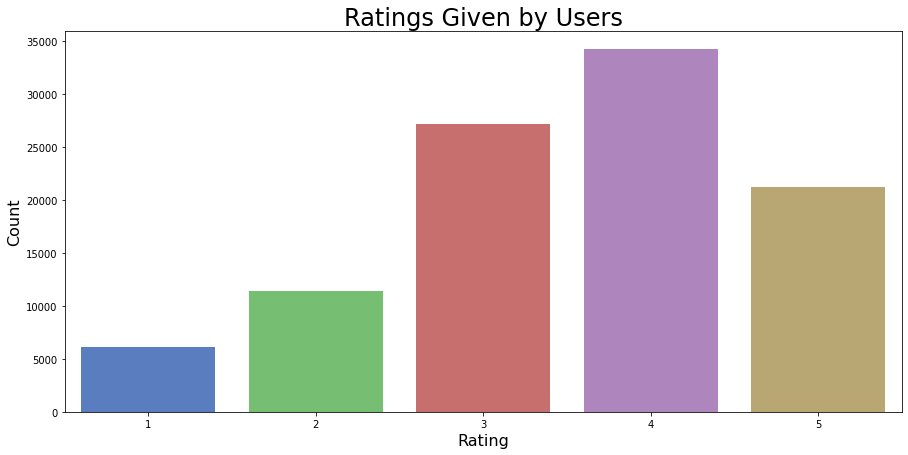

In [ ]:
sns.countplot(x=rating_df.rating)
plt.xlabel("Rating", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Ratings Given by Users", fontsize=24)
plt.show()

In [ ]:
rating_df["rating"].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

The majority of ratings given by users are greater than 3. This can speak to the tendency of users generally having positive opinions about movies, or that users do not rate movies they have not enjoyed. It might also be due to how different users perceive ratings; some users might consider a 3 star rating to be average, while others might consider it as terrible. The imbalance of ratings may pose a challenge: a simple algorithm that always predicts a rating between 3 and 5 may be quite effective already, and might be hard to beat by our recommender system.

In [ ]:
movies = rating_df.groupby('itemID').agg({'rating': ['count', np.mean]})

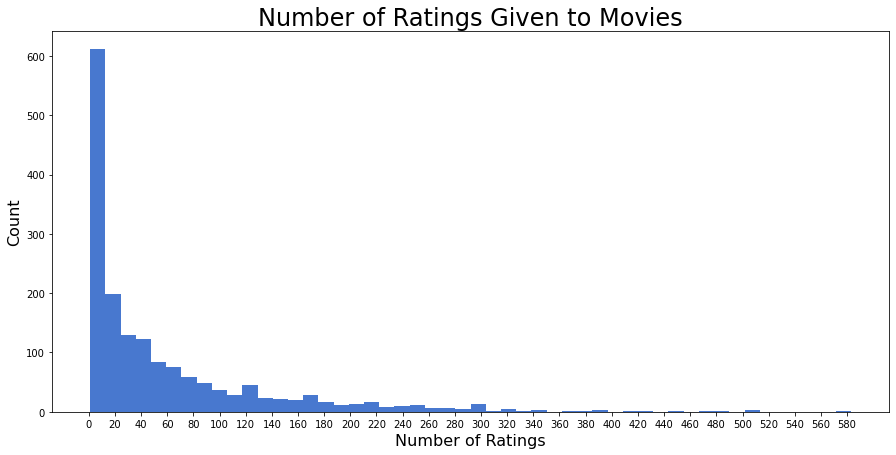

In [ ]:
plt.hist(movies[('rating', 'count')], bins=50)
plt.xticks(np.arange(0, max(movies[('rating', 'count')])+1, 20))
plt.xlabel("Number of Ratings", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Number of Ratings Given to Movies", fontsize=24)
plt.show()

The majority of movies have received fewer than 40 ratings from users, which may make understanding the latent features of movies a challenge. Still, a sizeable amount of movies have received many ratings.

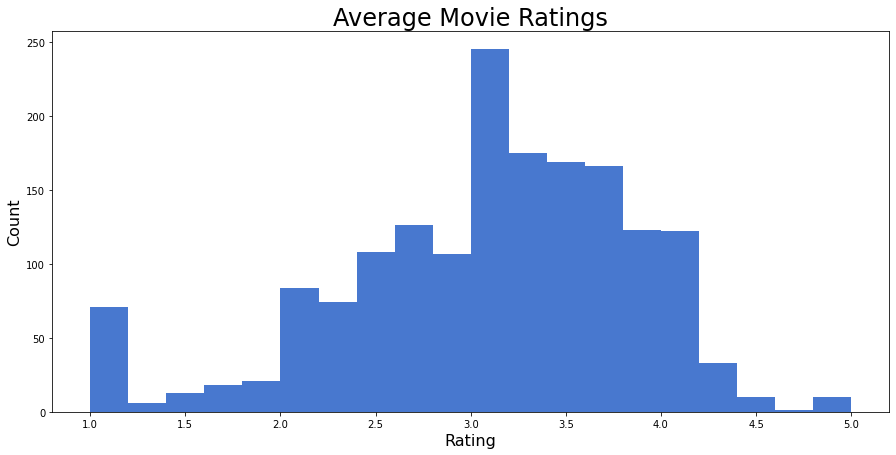

In [ ]:
plt.hist(movies[('rating', 'mean')], bins=20)
plt.xlabel("Rating", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Average Movie Ratings", fontsize=24)

plt.show()

The above plot corresponds with what we observed when looking at the ratings users generally give: the average movie ratings also tend to be above 3.0, but in this case the ratings imbalance is not as severe as previously. This suggests that a movie that has received many ratings has received both high and low ones.

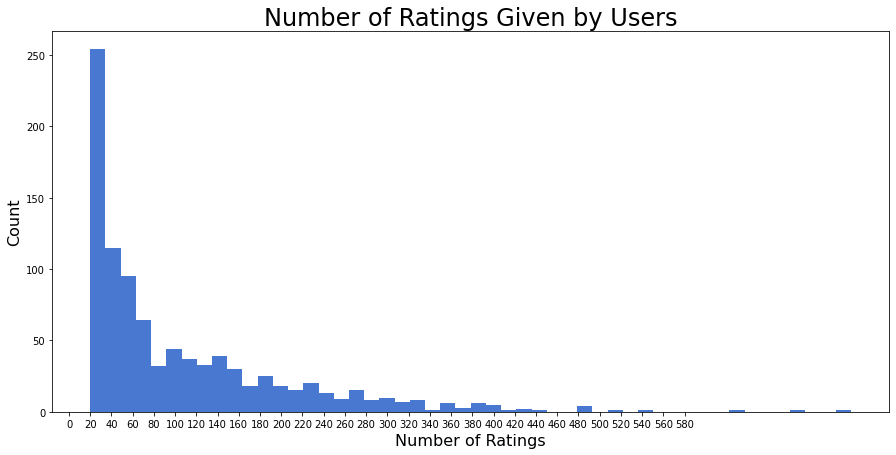

In [ ]:
users = rating_df.groupby('userID').agg({'rating': ['count', np.mean, lambda x: x.value_counts().index[0]]})

plt.hist(users[('rating', 'count')], bins=50)
plt.xticks(np.arange(0, max(movies[('rating', 'count')])+1, 20))
plt.xlabel("Number of Ratings", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Number of Ratings Given by Users", fontsize=24)
plt.show()

Similarly to movies, most users have given a relatively small amount of ratings, but there exist many users who have given many.

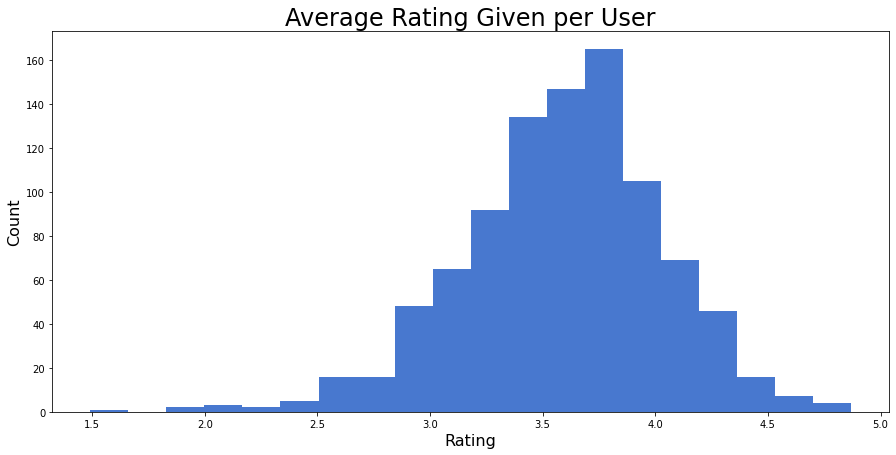

In [ ]:
plt.hist(users[('rating', 'mean')], bins=20)
plt.xlabel("Rating", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Average Rating Given per User", fontsize=24)

plt.show()

The average ratings users give seem to approximately follow a normal distribution centered around 3.5

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


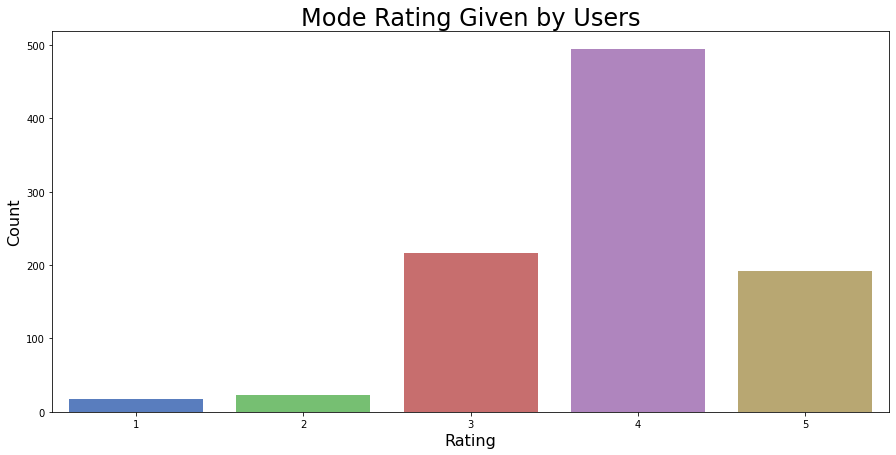

In [ ]:
sns.countplot(users[('rating', '<lambda_0>')])
plt.title("Mode Rating Given by Users", fontsize=24)
plt.xlabel("Rating", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show()

Per user, the most common rating given is clearly 4, but there are users who most frequently give out 3s and 5s. There exist very few users who most often give movies a 1 or 2.

# Brainstorming

In reality, there are so many different variables that could affect a users rating for a given movie. The interface a user sees for providing ratings can affect the rating itself: exposure to other users' or critics' ratings can affect the user's opinion, while a very inconvenient user interface may mean users only bother to rate movies when they have strong feelings about them. Similar to critics' opinion on a movie, a users rating can also be affected by the box office success of the movie.

A users rating for a movie does not only have to depend on what the user thinks of the movie, but it can also be affected by the users opinion of the movie's cast and the directing staff. Even if a user sees a movie just once, the rating they would give for it may change over time - if the movie is one the user saw very long ago, they might have a sense of nostalgia about it and thus appreciate it more. Likewise, as actors are public figures and often get into scandals, which might affect the user's perception of them, and hence possibly the user's opinion of the movies the actors have starred in.

These are just some of the uncountably many additional variables that may affect a user's rating. Unfortunately, most of them are near impossible to objectively measure and thus to account for in our models. Still, we could try obtaining some of the data by combining our dataset with professional critics' ratings and information about how well the movies did in cinemas. Of course, any model is likely to see an improvement by having more data to train on, so combining our dataset with, for example, the Netflix Prize competition dataset could yield better results. 



# Model Staircase

We propose the following model staircase: 

**Model One:**
 - User ratings are independent and identically normally distributed with an average of 3.53 and a standard deviation of 1.13. (Where 3.53 is the mean rating given for all movies). 

**Model Two:**
 - User ratings are independent, but are normally distributed with their own average rating. 

**Model Three:**
 - User ratings are conditionally dependent on some movie features (average rating, genre, etc), i.e 
 
 $ p(X | \textbf{M}) \sim N(\mu_i, \sigma_i) $ 

 Where $X$ is the rating given movie features $\textbf{M}$ for a user $i$. 

**Model Four:**

- User ratings depend on some linear combination of latent user and movie features (PMF)

**Model Five**

- User ratings depend on some non-linear combination of latent user and movie features (PMF extension 1)

**Model Six:**

- The probabilty of a user giving a movie a certain rating depend of some combination of latent user and movie features (PMF extension 2)



## Support functions and variables

In [ ]:
from tqdm.auto import tqdm

In [ ]:
big_array = rating_df.values
big_array[:, :2] = big_array[:, :2]-1 # Fixes off by one error

# Make train, validation, and test splits
train_mat = big_array[:80000, :]
valid_mat = big_array[80000:90000, :]
test_mat =  big_array[90000:100000, :]

train_inputs, train_targets = train_mat[:, :2], train_mat[:, 2].astype(jnp.float32)
val_inputs, val_targets = valid_mat[:, :2], valid_mat[:, 2].astype(jnp.float32)
test_inputs,  test_targets  = test_mat[:, :2],  test_mat[:, 2].astype(jnp.float32)


In [ ]:
def plot_training_curves(train_history, val_history):
  plt.plot(train_history, label="train")
  plt.plot(val_history, label="validation")
  plt.legend()
  plt.xlabel("Iterations")
  plt.title("Training curves")

In [ ]:
def rmse(preds, target):
  return jnp.mean(jnp.sqrt((preds - target)**2))

# Model 1

Model 1 is the most basic model: it assumes that user ratings are independently and identically distributed as a normal distribution with the same mean and variance across all users.

In [ ]:
mean, global_sd = rating_df["rating"].mean(), rating_df["rating"].std()
preds = np.random.normal(mean, global_sd, size=val_inputs.shape[0])
print(f"Model 1 validation RMSE: {rmse(preds, val_targets)}")

Model 1 validation RMSE: 1.261194109916687


# Model 4

Model 4 is the vanilla probabalistic matrix factorization solution, where we assume that the ratings users give can be described as a linear combination of matrices representing user and movie latent features. 

In [ ]:
# Model implementation in JAX (https://github.com/google/jax)

# Optimization hyperparameters
step_size = 100.0
train_iters = 1500

# Model hyperparameters
num_factors = 3
init_scale = 0.1
latent_param_regularization = 0.1

# Init parameters
user_latents  = np.random.randn(num_users, num_factors) * init_scale
movie_latents = np.random.randn(num_items, num_factors) * init_scale
params_m4 = (user_latents, movie_latents)

# Actual model
mean_rating = jnp.mean(train_targets)
def pmf4_predict(user_latents, movie_latents, inputs):
  (user_index,   movie_index) = (inputs[:, 0], inputs[:, 1])

  return jnp.sum(user_latents[user_index] * movie_latents[movie_index], axis=1) + mean_rating

def regularization_loss(user_latents, movie_latents):
  return latent_param_regularization * (jnp.mean(user_latents**2) + jnp.mean(movie_latents**2))

def prediction_mse(params, inputs, targets):
  preds = pmf4_predict(*params, inputs)
  return (preds - targets)**2

def training_loss(params, inputs, targets):
  return regularization_loss(*params) + jnp.mean(prediction_mse(params, inputs, targets), axis=0)

# One training step
@jit  # Pre-compiles the function to speed up training.
def sgd_update(params, i):  # Stochastic gradient descent
  (grads_user, grads_movie) = grad(training_loss)(params, train_inputs, train_targets)
  (user_latents, movie_latents) = params
  return (user_latents  - step_size * grads_user,  # one step of gradient descent
          movie_latents - step_size * grads_movie)

# Main training loop
# print('i', 'train loss', 'train RMSE', 'test RMSE')
train_rmses = []
val_rmses = []
for i in tqdm(range(train_iters)):
  params_m4 = sgd_update(params_m4, i)
  if i % 50 == 0:
    # Print current progress
    train_rmse = jnp.mean(jnp.sqrt(prediction_mse(params_m4, train_inputs, train_targets)))
    val_rmse  = jnp.mean(jnp.sqrt(prediction_mse(params_m4, val_inputs, val_targets)))
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)


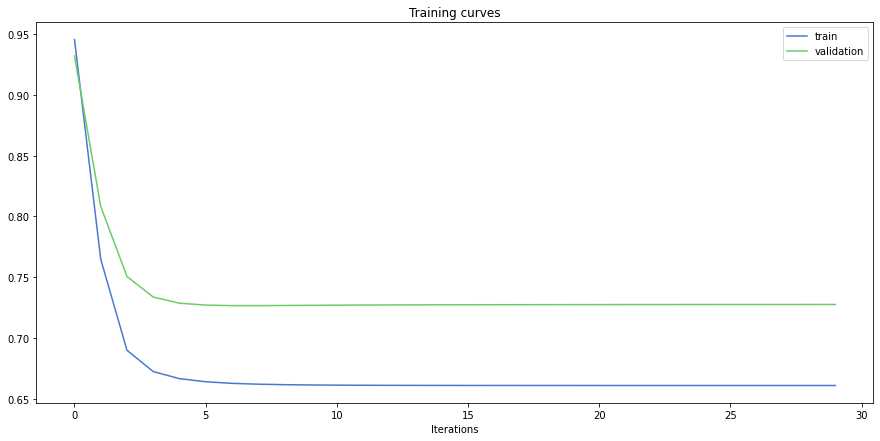

In [ ]:
plot_training_curves(train_rmses, val_rmses)

# Model 5


Model 5 is an extension of model 4, where the final rating predictions are obtained by running the linear combination of the latent matrices through a [custom sigmoid activation function](https://www.desmos.com/calculator/szclaip7ua).

In [ ]:
def activation(x):
  return 4 / (1 + jnp.exp(-0.8*x))

In [ ]:
# Model implementation in JAX (https://github.com/google/jax)

# Optimization hyperparameters
step_size = 100.0
train_iters = 1500

# Model hyperparameters
num_factors = 3
init_scale = 0.1
latent_param_regularization = 0.1

# Init parameters
user_latents  = np.random.randn(num_users, num_factors) * init_scale
movie_latents = np.random.randn(num_items, num_factors) * init_scale
params_m5 = (user_latents, movie_latents)

# Actual model
mean_rating = jnp.mean(train_targets)
def pmf5_predict(user_latents, movie_latents, inputs):
  (user_index,   movie_index) = (inputs[:, 0], inputs[:, 1])

  return activation(
      jnp.sum(user_latents[user_index] * movie_latents[movie_index], axis=1) + mean_rating) + 1

def regularization_loss(user_latents, movie_latents):
  return latent_param_regularization * (jnp.mean(user_latents**2) + jnp.mean(movie_latents**2))

def prediction_mse(params, inputs, targets):
  preds = pmf5_predict(*params, inputs)
  return (preds - targets)**2

def training_loss(params, inputs, targets):
  return regularization_loss(*params) + jnp.mean(prediction_mse(params, inputs, targets), axis=0)

# One training step
@jit  # Pre-compiles the function to speed up training.
def sgd_update(params, i):  # Stochastic gradient descent
  (grads_user, grads_movie) = grad(training_loss)(params, train_inputs, train_targets)
  (user_latents, movie_latents) = params
  return (user_latents  - step_size * grads_user,  # one step of gradient descent
          movie_latents - step_size * grads_movie)

train_rmses = []
val_rmses = []
for i in tqdm(range(train_iters)):
  params_m5 = sgd_update(params_m5, i)
  if i % 50 == 0:
    # Print current progress
    train_rmse = jnp.mean(jnp.sqrt(prediction_mse(params_m5, train_inputs, train_targets)))
    val_rmse  = jnp.mean(jnp.sqrt(prediction_mse(params_m5, val_inputs, val_targets)))
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)


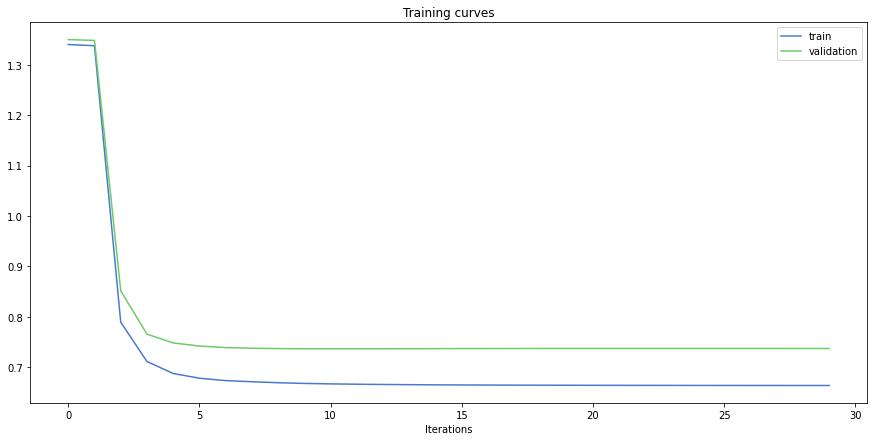

In [ ]:
plot_training_curves(train_rmses, val_rmses)

# Model 6

Model 6 is a more complex extension of model 4. We have designed the user latent matrix such that every user has 5 latent vectors. Every such vector corresponds to one rating (1-5) and describes how likely a user is to rate a movie with the corresponding rating. The movie latent vectors describe how much the movies have the features that affect the users' probability of giving specific ratings. Thus, we can use a softmax activation for our final predictions and treat this as a classification problem with 5 classes, i.e. ratings 1-5.

In [ ]:
def softmax(x, temperature=1):
  e_x = jnp.exp(temperature*x)
  return e_x / jnp.sum(e_x, axis=1).reshape(-1, 1)

In [ ]:
def one_hot_encode(targets):
  one_hot = np.zeros((targets.shape[0], 5))
  one_hot[np.arange(targets.shape[0]), (targets-1).astype(int)] = 1.0
  return one_hot
  

In [ ]:
# Model implementation in JAX (https://github.com/google/jax)

# Optimization hyperparameters
step_size = 100.0
train_iters = 1500

# Model hyperparameters
num_factors = 2
init_scale = 0.1
latent_param_regularization = 0.1

# Init parameters
user_latents  = np.random.randn(num_users, num_factors, 5) * init_scale
# movie_latents = np.random.randn(num_items, num_factors, 5) * init_scale
movie_latents = np.random.randn(num_items, num_factors, 1) * init_scale
params_m6 = (user_latents, movie_latents)
params_over_time = []

# Actual model
mean_rating = jnp.mean(train_targets)
def pmf6_predict(user_latents, movie_latents, inputs):
  (user_index,   movie_index) = (inputs[:, 0], inputs[:, 1])
  logits = jnp.sum(user_latents[user_index] * movie_latents[movie_index], axis=1)
  return softmax(logits, temperature=1)

def regularization_loss(user_latents, movie_latents):
  return latent_param_regularization * (jnp.mean(user_latents**2) + jnp.mean(movie_latents**2))

# Cross Entropy for categorical distribution 
def prediction_ce(params, inputs, targets):
  preds = pmf6_predict(*params, inputs)
  return -jnp.sum(targets*jnp.log(preds), axis=1)

def training_loss(params, inputs, targets):
  return regularization_loss(*params) + jnp.mean(prediction_ce(params, inputs, targets), axis=0)

# One training step
@jit  # Pre-compiles the function to speed up training.
def sgd_update(params, i):  # Stochastic gradient descent
  (grads_user, grads_movie) = grad(training_loss)(params, train_inputs, one_hot_encode(train_targets))
  (user_latents, movie_latents) = params
  return (user_latents  - step_size * grads_user,  # one step of gradient descent
          movie_latents - step_size * grads_movie)

# Main training loop
train_rmses = []
val_rmses = []
for i in tqdm(range(train_iters)):
  params_m6 = sgd_update(params_m6, i)
  if i % 50 == 0:
    # Print current progress
    params_over_time.append(params_m6)
    train_rmse = jnp.mean(prediction_ce(params_m6, train_inputs, one_hot_encode(train_targets)))
    val_rmse  = jnp.mean(prediction_ce(params_m6, val_inputs, one_hot_encode(val_targets)))
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)


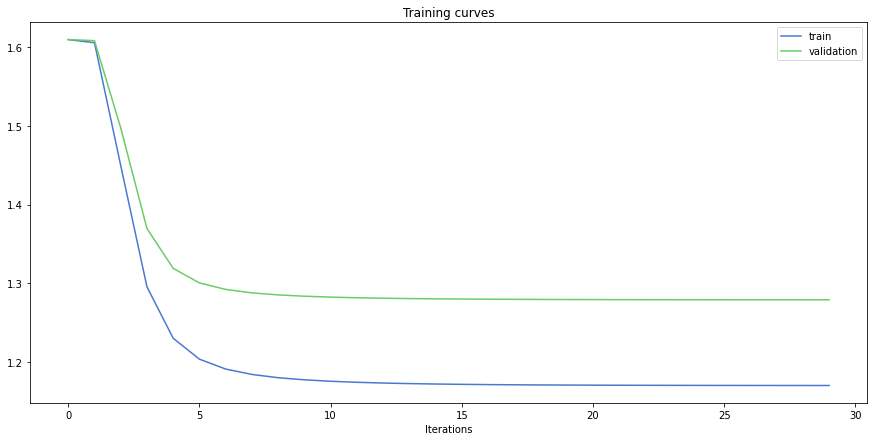

In [ ]:
plot_training_curves(train_rmses, val_rmses)

In [ ]:
pmf6_predict(*params_m6, train_inputs)[2]

DeviceArray([0.670817  , 0.09540344, 0.14083157, 0.07012969, 0.0228184 ],            dtype=float32)

# Model Evaluation

We choose two ways to evaluate our models: RMSE and classification accuracy, where we treat each rating as a class. For models 1, 4 and 5, we have rounded the predicted ratings to the nearest integer. Predictions that are greater than 5 are rounded down to 5, and likewise predictions below 1 are rounded up to 1.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
def round_predictions(raw_predictions):
  new = np.rint(raw_predictions)
  new[new > 5] = 5
  new[new < 1] = 1
  return new

In [ ]:
def plot_confusion(preds, targets, name):
  plt.imshow(confusion_matrix(preds, targets, normalize="true"), cmap="Blues")
  plt.clim(0, 1)
  plt.colorbar()
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.xticks(range(0, 5), labels=range(1, 6))
  plt.yticks(range(0, 5), labels=range(1, 6))
  plt.title(name)


### Model 1

Model 1 is very unsuccessful and does a poor job capturing the complexity of the task.

In [ ]:
new_preds = round_predictions(np.random.normal(mean, global_sd, size=test_inputs.shape[0]))
print("Accuracy:", accuracy_score(new_preds, test_targets))
print("RMSE:", rmse(new_preds, test_targets))

Accuracy: 0.2575
RMSE: 1.1957


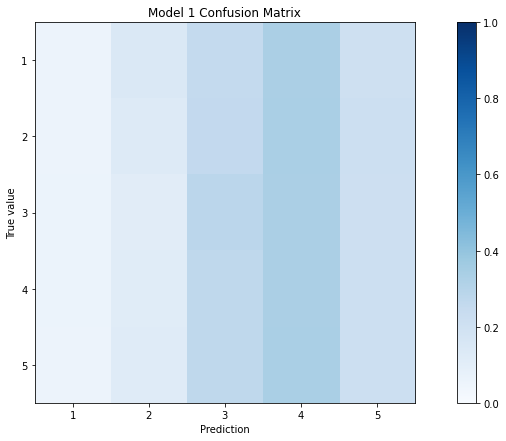

In [ ]:
plot_confusion(new_preds, test_targets, "Model 1 Confusion Matrix")

### Model 4


Model 4 provides much more promising results. We see a sizeable increase in both classification accuracy and RMSE. The confusion matrix shows that the model does an excellent job predicting ratings on both ends of the range (1 and 5), and generally gives close-to-true or precise predictions for ratings inbetween.

In [ ]:
new_preds = round_predictions(pmf4_predict(*params_m4, test_inputs))
print("Accuracy:", accuracy_score(new_preds, test_targets))
print("RMSE:", rmse(new_preds, test_targets))

Accuracy: 0.42
RMSE: 0.694


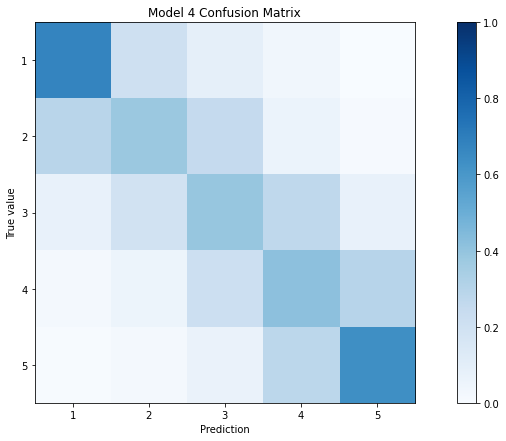

In [ ]:
plot_confusion(new_preds, test_targets, "Model 4 Confusion Matrix")

### Model 5

Model 5 is still an improvement over model 1, but we can see it performs worse than its simpler counterpart model 4. Besides its worse accuracy and RMSE scores, we also observe that it frequently makes noisy predictions for ratings that in actuality were equal to 2.

In [ ]:
new_preds = round_predictions(pmf5_predict(*params_m5, test_inputs))
print("Accuracy:", accuracy_score(new_preds, test_targets))
print("RMSE:", rmse(new_preds, test_targets))

Accuracy: 0.4173
RMSE: 0.7079


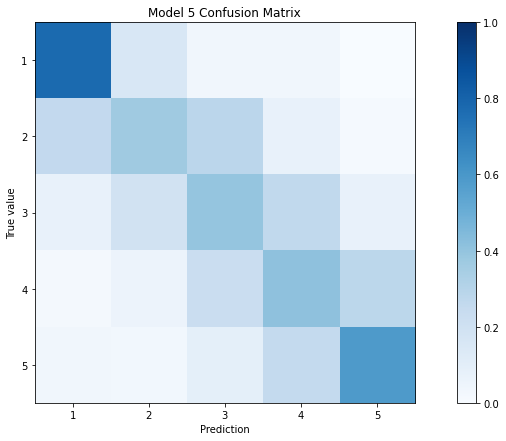

In [ ]:
plot_confusion(new_preds, test_targets, "Model 5 Confusion Matrix")

### Model 6: 

In terms of raw predictions, it is difficult to say if model 6 is an improvement over model 4: model 6 obtains a better classification accuracy, but a slightly worse RMSE score.

However, it appears that with the purpose of making recommendations, model 6 may prove to be more useful. While the differences are subtle, the confusion matrix shows that model 6 accounts for the bias in ratings by predicting ratings in the 3-5 more frequently and with higher accuracy, even if the proportion of true positives for rating 5 has slightly decreased.

In [ ]:
new_preds = pmf6_predict(*params_m6, test_inputs).argmax(axis=1) + 1
print("Accuracy:", accuracy_score(new_preds, test_targets))
print("RMSE:", rmse(new_preds, test_targets))

Accuracy: 0.4419
RMSE: 0.7356


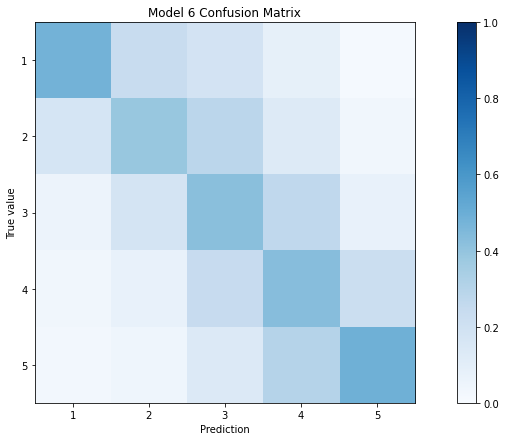

In [ ]:
plot_confusion(new_preds, test_targets, "Model 6 Confusion Matrix")

# Latent Variables and their meaning

We can attempt to interpret the latent variables in our matrices.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def plot_params(Time):
  (user_latents, movie_latents) = params_over_time[Time]

  for i in range(5):
    plt.scatter(user_latents[:, 0, i], user_latents[:, 1, i], label=f"Rating {i+1}", alpha=0.4)
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    
  plt.legend()
  plt.title(f"User latent paramaters at iter {Time*50}")

slider = widgets.IntSlider(min=0, max=len(params_over_time)-1)
_ = interact(plot_params, Time=slider)

interactive(children=(IntSlider(value=0, description='Time', max=29), Output()), _dom_classes=('widget-interac…

From the interactive graph above, we can see that the latent vectors for each rating start to seperate as training progresses. Generally, we can see that the latent vectors for 1-rated and 5-rated get further apart as iterations increase. This has the real life interpretation that movies that are rated 1 and rated 5 by users are likely to be different from each other. 

We can also see that there is some form of clustering occuring. This has the real life interpretation that there is a general consensus on the quality of any given movie.

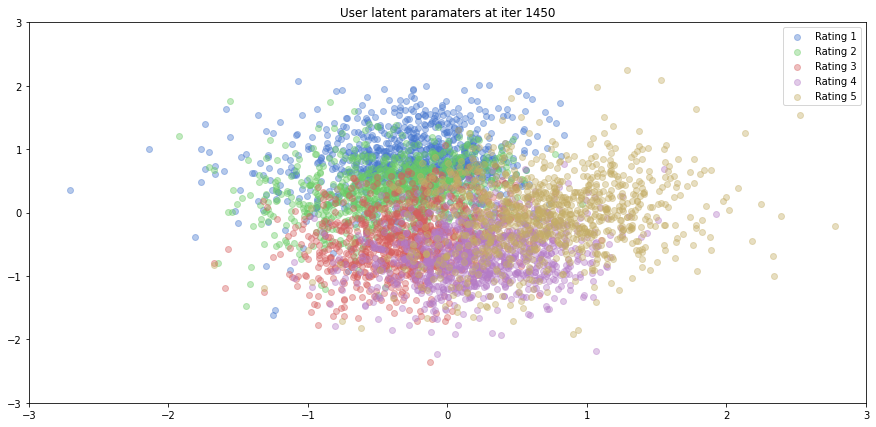

In [ ]:
plot_params(len(params_over_time)-1)

In [ ]:
# Star wars: 49
# Princess bride: 172
# Titanic: 312
# Flintstones: 382
# Mr Magoo: 900
# Judge Dredd: 372

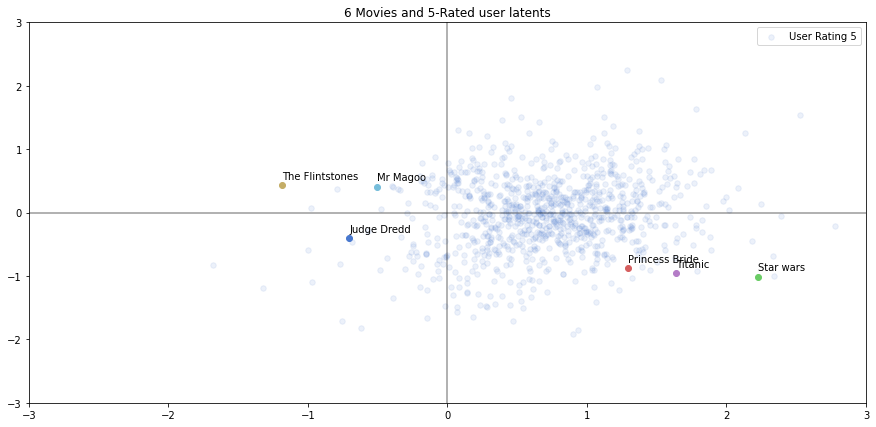

In [ ]:
(user_latents, movie_latents) = params_m6
plt.scatter(user_latents[:, 0, 4], user_latents[:, 1, 4], alpha=0.1, s=30, label="User Rating 5")

plt.scatter(movie_latents[49, 0], movie_latents[49, 1])
plt.text(movie_latents[49, 0], movie_latents[49, 1]+0.1, "Star wars")

plt.scatter(movie_latents[172, 0], movie_latents[172, 1])
plt.text(movie_latents[172, 0], movie_latents[172, 1]+0.1, "Princess Bride")

plt.scatter(movie_latents[312, 0], movie_latents[312, 1])
plt.text(movie_latents[312, 0], movie_latents[312, 1]+0.1, "Titanic")

plt.scatter(movie_latents[382, 0], movie_latents[382, 1])
plt.text(movie_latents[382, 0], movie_latents[382, 1]+0.1, "The Flintstones")

plt.scatter(movie_latents[900, 0], movie_latents[900, 1])
plt.text(movie_latents[900, 0], movie_latents[900, 1]+0.1, "Mr Magoo")

plt.scatter(movie_latents[372, 0], movie_latents[372, 1])
plt.text(movie_latents[372, 0], movie_latents[372, 1]+0.1, "Judge Dredd")

plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.vlines(0, ymax=3, ymin=-3, alpha=0.4)
plt.hlines(0, xmax=3, xmin=-3, alpha=0.4)
plt.legend()
_ = plt.title("6 Movies and 5-Rated user latents")

In the graph above, we have plotted the latent vector for 5-rated movies for users. We have highlighted several movies to demonstrate the meaning of the latent variables. 

We chose 3 movies that were critically acclaimed: The Princess bride, Titanic and Star wars. We can see that they are located near the latent vectors for 5-rated movies (with a cosine distance metric). 

We also chose 3 movies that were considered terrible: The Flintstones, Mr. Magoo, and Judge Dredd (These movies were [chosen from this list](https://screenrant.com/worst-movies-1990s-according-rotten-tomatoes/)). We can see that they are located further from the latent vectors (with a cosine distance metric). 



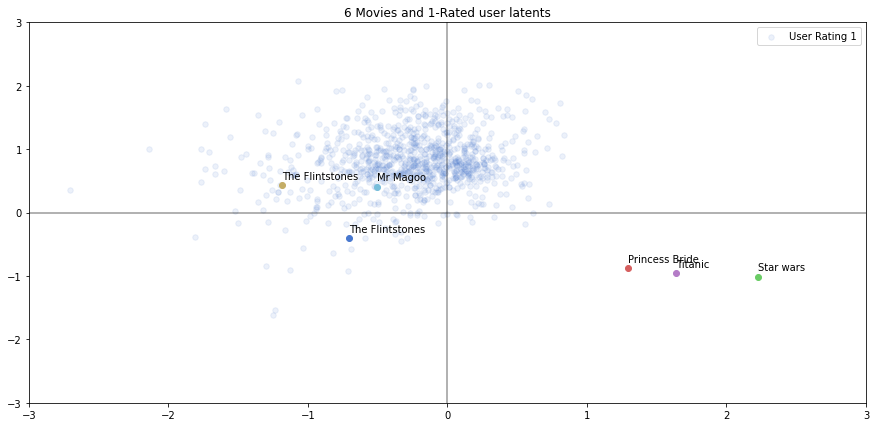

In [ ]:
plt.scatter(user_latents[:, 0, 0], user_latents[:, 1, 0], alpha=0.1, s=30, label="User Rating 1")

plt.scatter(movie_latents[49, 0], movie_latents[49, 1])
plt.text(movie_latents[49, 0], movie_latents[49, 1]+0.1, "Star wars")

plt.scatter(movie_latents[172, 0], movie_latents[172, 1])
plt.text(movie_latents[172, 0], movie_latents[172, 1]+0.1, "Princess Bride")

plt.scatter(movie_latents[312, 0], movie_latents[312, 1])
plt.text(movie_latents[312, 0], movie_latents[312, 1]+0.1, "Titanic")

plt.scatter(movie_latents[382, 0], movie_latents[382, 1])
plt.text(movie_latents[382, 0], movie_latents[382, 1]+0.1, "The Flintstones")

plt.scatter(movie_latents[900, 0], movie_latents[900, 1])
plt.text(movie_latents[900, 0], movie_latents[900, 1]+0.1, "Mr Magoo")

plt.scatter(movie_latents[372, 0], movie_latents[372, 1])
plt.text(movie_latents[372, 0], movie_latents[372, 1]+0.1, "The Flintstones")

plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.vlines(0, ymax=3, ymin=-3, alpha=0.4)
plt.hlines(0, xmax=3, xmin=-3, alpha=0.4)
plt.legend()
_ = plt.title("6 Movies and 1-Rated user latents")

On the contrary, we can see that the "bad" movies are located closer to the latent vectors for 1-rated movies. (bad is in quotations here in case one of them happens to be a favorite of yours)

# Conclusion

The purpose of our models was to predict the ratings users would give to movies based on their previous rating history such that we would be able to provide recommendations to users. 

We began by randomly splitting the data into training/validation/testing sets with an 8:1:1 ratio split. This allowed our training data to likely contain a good amount of ratings for each user in the dataset so we would not be predicting users’ ratings without having seen some of them before. However, by doing so we may have lost any information that might be contained in when ratings are treated as a time series.

Visualization of the dataset showed one clear-cut problem: the ratings users give are imbalanced and biased towards the higher end of ratings, whereas low ratings are given much less frequently. A good understanding of what the user likes vs. what they don’t like is key to providing good recommendations, which is why we considered this ratings imbalance as the key to improving our solutions.

Our baseline model is a normal distribution with global mean and variance from which we randomly sample the rating a user will give for a given movie. Evaluation of the baseline model shows that it does a horrible job at capturing the complexity of the task at hand. However, our three PMF solutions comfortably beat the baseline, showing a near 20% increase in classification accuracy and approximately a two-fold decrease in RMSE. Model 4, which was the vanilla PMF, was not improved on with the implementation of a non-linear combination of latent matrices when generating predictions as both accuracy measures decreased. However, model 6, in which the user latent matrix captures the probability of a user giving every rating for a movie, showed a slight improvement over model 4 in terms of classification, yet produced a slightly lower RMSE score. Most encouragingly, perhaps, model 6 proved to be much more successful in correctly predicting ratings in the 3-5 range by accounting for the bias in ratings. This means that model 6 would be most successful in helping us provide recommendations that the users are likely to appreciate. This improvement is debatable, however, so to truly make a distinction we could try A/B testing the systems on our service.

Overall, the results are very promising. If we suppose that we only recommend movies for which we predict a rating of 3 or above, our PMF implementations would enable our recommendations to be accurate in over 50% of the cases vs. when using the baseline model. Furthermore, using the PMF solutions would stop us from making recommendations which the user might end up hating, potentially avoiding customers becoming upset, as the baseline model predicts most ratings to be on the higher end.

We would expect our models to struggle with new users for whom we do not have an extensive rating history, so our model accuracies would likely decrease as new customers join the service. However, we need not make recommendations to such users and instead we can prompt them to rate movies as they start using the service, and give recommendations only when we have sufficient data. In the meanwhile, we can display movies that most people have enjoyed.
